Import the neccessary libraries

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from tqdm import tqdm           # creates progress bars
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, locally_linear_embedding
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.style.use('fivethirtyeight')


We choose 5  article types and load the data from newsgroups dataset. \
We also a frequency bar plot of each subject. 

  -  "alt.atheism",
  -  'talk.politics.guns',
   - "comp.graphics",
  -  "sci.space",
   - 'rec.sport.baseball',

4663 documents in 5 categories


<Figure size 432x288 with 0 Axes>

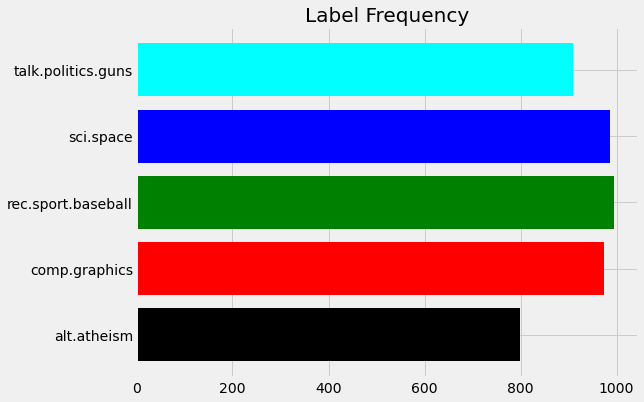

In [29]:
categories = [
    "alt.atheism",
    'talk.politics.guns',
    "comp.graphics",
    "sci.space",
    'rec.sport.baseball',
]
# remove headers and other unnecessary info
newsgroups = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True
)

labels = newsgroups.target
label_names = newsgroups.target_names
true_k = len(label_names)
print(f"{len(newsgroups.data)} documents in {true_k} categories")

# print frequency barplot of each subject.
my_colors = ['black', 'red', 'green', 'blue', 'cyan']
plt.clf()
plt.figure(figsize=(8, 6))
unique_elements, element_counts = np.unique(labels, return_counts=True)
plt.barh(label_names, element_counts, color=my_colors)
plt.title('Label Frequency', fontsize=20)
plt.show()


**Feature extraction** 

1. TfidfVectorizer uses an in-memory vocabulary (a Python dict) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus. 
- We ignore terms that appear in more than 50% of the documents (as set by max_df=0.5).
- We ignore terms that are not present in at least 2 documents (set by min_df=2).
- The resulting number of unique terms n_features is around 20K.



2. TruncatedSVD is a technique to perform dimensionality reduction with the Singular Value Decomposition method. However, it also works on sparse data like the ones extracted from TFidf.
- We keep 800 components
- These components explain 51.5% of the variance in the dataset.

In [43]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,  # ignore terms that appear in more than 50% of the documents
    min_df=2,    # ignore terms that are not present in at least 2 documents
    stop_words="english",
)
X = tfidf_vectorizer.fit_transform(newsgroups.data)
print('Samples: ', X.shape[0])
print('Tfid features: ', X.shape[1])

# use a normalizer since SVD will "break" the normalization.
lsa = make_pipeline(TruncatedSVD(n_components=800), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print('Features after SVD (LSA features):', X_lsa.shape[1])
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


Samples:  4663
Tfid features:  20382
Features after SVD (LSA features): 800
Explained variance of the SVD step: 51.5%


### Visualizing the dataset is always a helpful way to understand it better. 
1. Visualizing feature pairs
2. Projecting to 2D and 3D using **T-SNE** and **LLE**

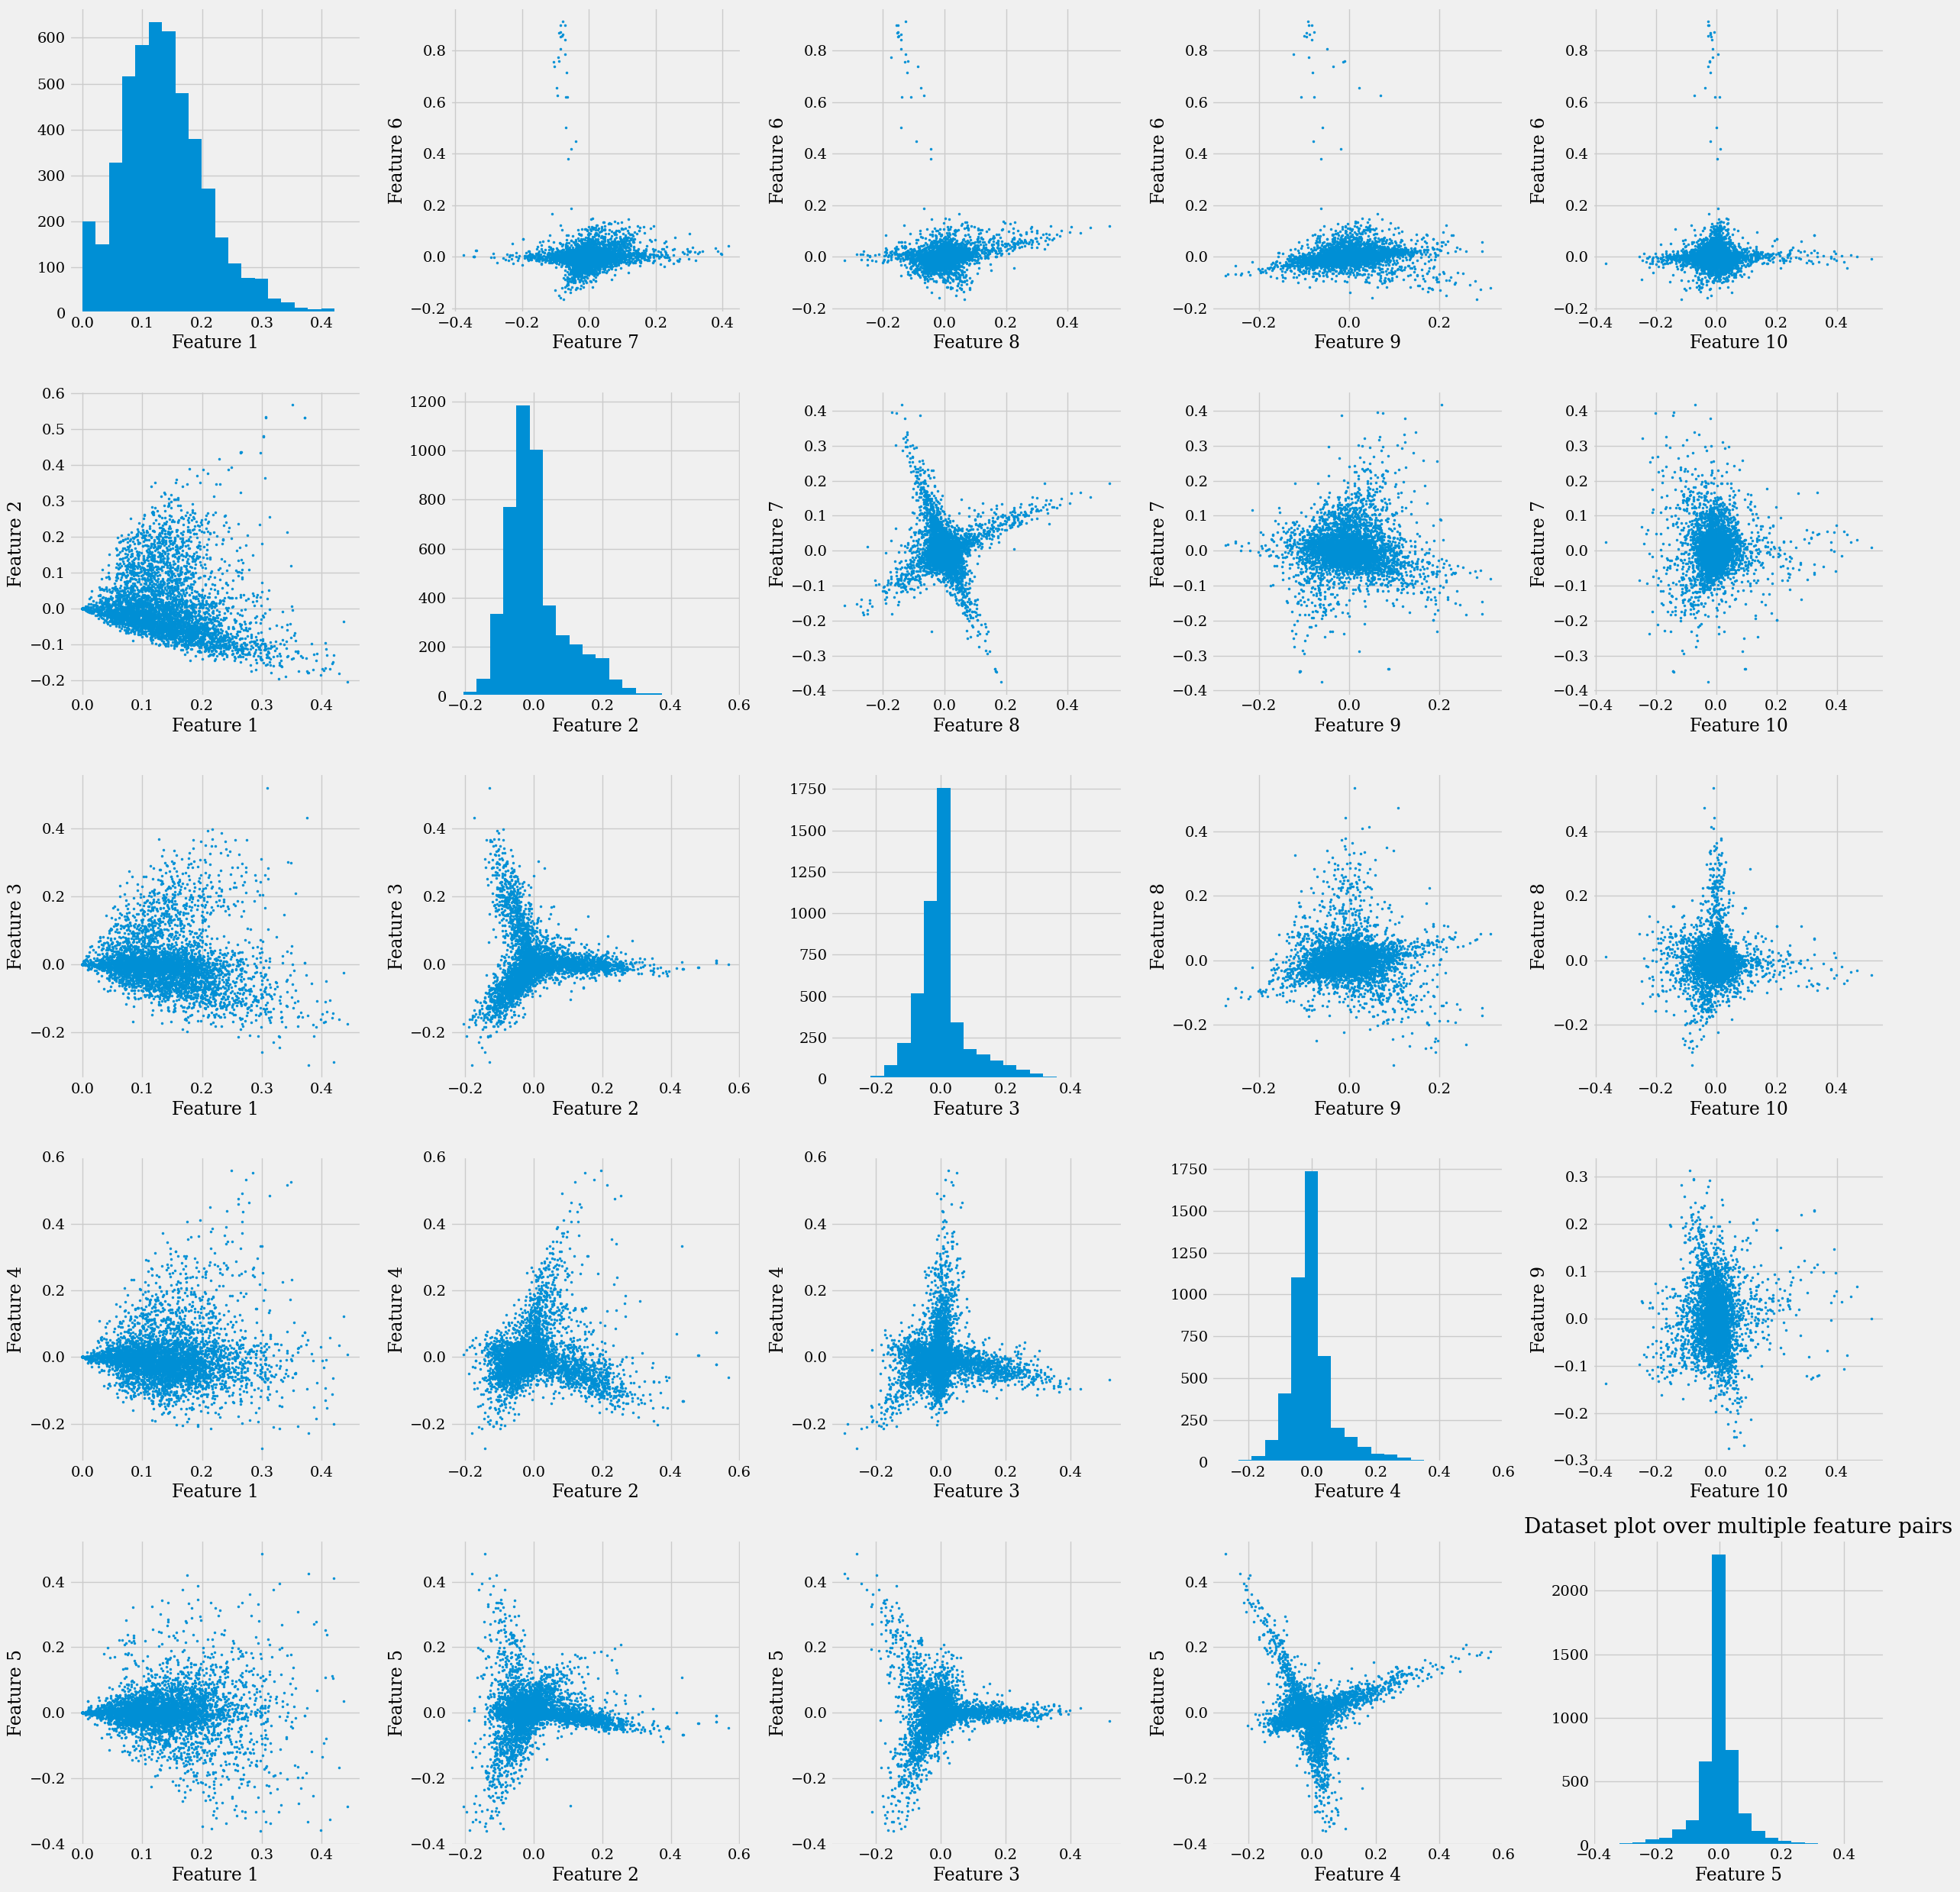

In [102]:
# Create a dense grid of subplots with 5x5
fig, axs = plt.subplots(5, 5, figsize=(25, 25))

plot_feats = 5
# Iterate through each subplot, and plot the feature pairs
for i in range(plot_feats):
    for j in range(plot_feats):
        if i>j:
            axs[i, j].scatter(X_lsa[:, j], X_lsa[:, i], s=4)
            axs[i, j].set_xlabel('Feature ' + str(j+1))
            axs[i, j].set_ylabel('Feature ' + str(i+1))
        elif i<j:
            axs[i, j].scatter(X_lsa[:, plot_feats+j], X_lsa[:, plot_feats+i], s=4)
            axs[i, j].set_xlabel('Feature ' + str(j+1+plot_feats))
            axs[i, j].set_ylabel('Feature ' + str(i+1+plot_feats))
        else:
            axs[i, j].hist(X_lsa[:,i], bins=20)
            axs[i, j].set_xlabel('Feature ' + str(i+1))
plt.title('Dataset plot over multiple feature pairs')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

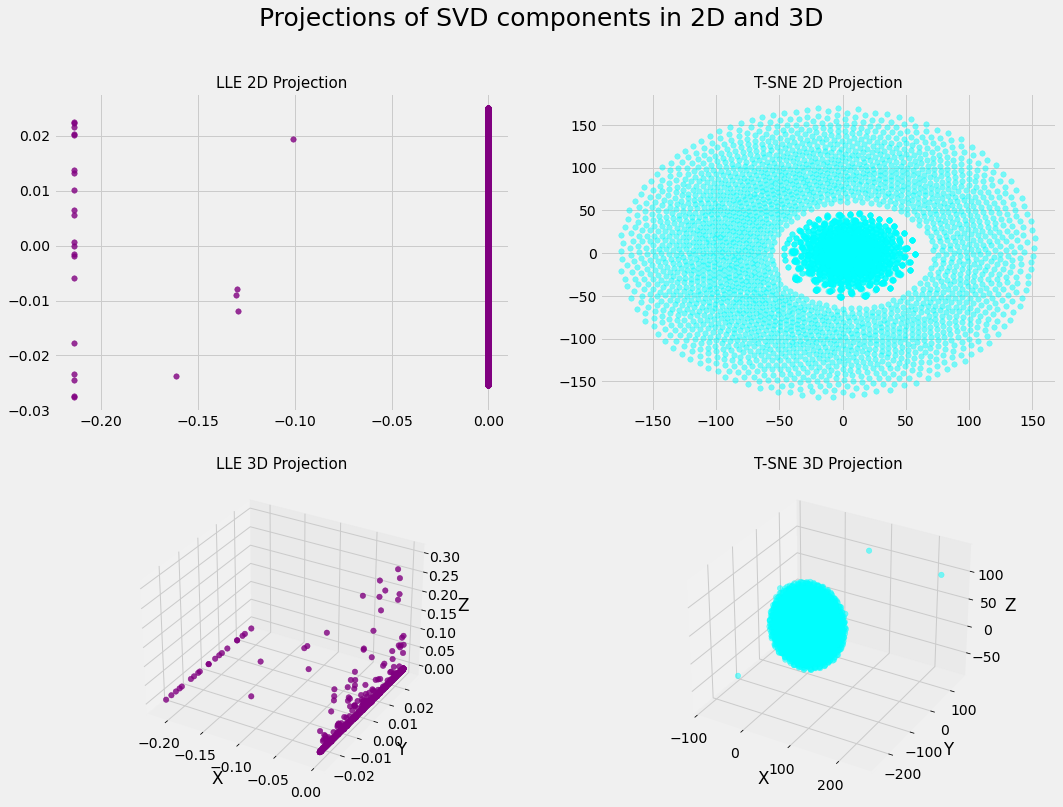

<Figure size 432x288 with 0 Axes>

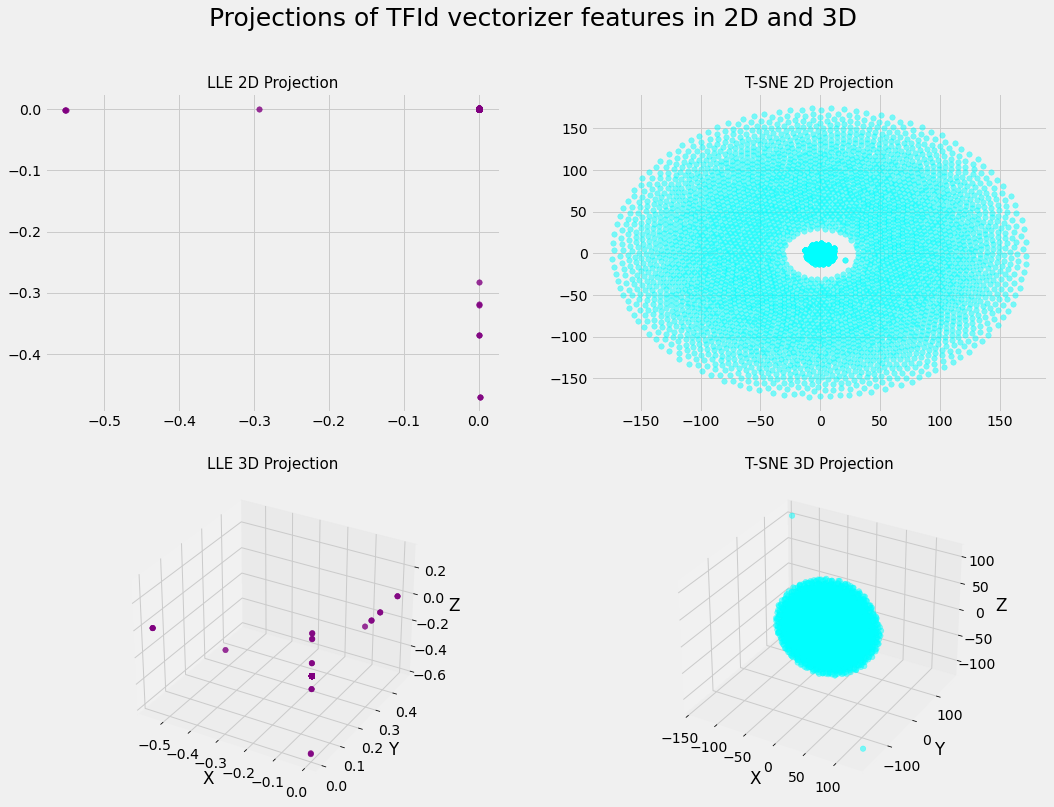

In [30]:
def project_data(dataset='original'):
    ''' Projects the dataset into 2D and 3D using TSNE and LLE techniques.
        Parameters:
            dataset (str): Either 'original' to visualize the TFid features
                            or 'lsa' to visualize the features after SVD.'''
    if dataset == 'original':
        lle_2d, lle_2d_err = locally_linear_embedding(
            X.todense(), n_neighbors=12, n_components=2)
        lle_3d, lle_3d_err = locally_linear_embedding(
            X.todense(), n_neighbors=12, n_components=3)
        tsne_2d = TSNE(2).fit_transform(X.todense())
        tsne_3d = TSNE(3).fit_transform(X.todense())
    elif dataset == 'lsa':
        lle_2d, lle_2d_err = locally_linear_embedding(
            X_lsa, n_neighbors=12, n_components=2)
        lle_3d, lle_3d_err = locally_linear_embedding(
            X_lsa, n_neighbors=12, n_components=3)
        tsne_2d = TSNE(2).fit_transform(X_lsa)
        tsne_3d = TSNE(3).fit_transform(X_lsa)
    return (tsne_2d, tsne_3d, lle_2d, lle_3d)

def visualize_dataset(data, title="Projection of dataset in 3D", figsize=(16, 12)):
    tsne_2d, tsne_3d, lle_2d, lle_3d = data
    # create figure and subplots
    plt.clf()
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')

    # plot data in first subplot
    ax1.scatter(lle_2d[:, 0], lle_2d[:, 1], s=30, alpha=0.8,color='purple')
    ax1.set_title('LLE 2D Projection', fontsize=15)
    ax2.scatter(tsne_2d[:, 0], tsne_2d[:, 1],  s=30, alpha=0.5,color='cyan')
    ax2.set_title('T-SNE 2D Projection', fontsize=15)

    # plot data in the third subplot
    ax3.scatter(lle_3d[:, 0], lle_3d[:, 1], zs=lle_3d[:, 2], s=30, alpha=0.8, color='purple')
    ax3.set_title('LLE 3D Projection', fontsize=15)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    # plot data in the forth subplot
    ax4.scatter(tsne_3d[:, 0], tsne_3d[:, 1],
                zs=tsne_3d[:, 2], s=30, alpha=0.5,color='cyan')
    ax4.set_title('T-SNE 3D Projection', fontsize=15)
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_zlabel('Z')

    plt.suptitle(title, fontsize=25)
    plt.show()


visualize_dataset(project_data(dataset='lsa'),
                  title=" Projections of SVD components in 2D and 3D")
visualize_dataset(project_data(dataset='original'),
                  title=" Projections of TFId vectorizer features in 2D and 3D")

In [41]:
def hac_evaluation(data,
                   n_clusters=[x for x in range(2, 10)],
                   linkage='ward',
                   sparse=False #in case SVD is not used and data is sparse
                   ):
   
    def plot_it(metric_name, scores):
        ''' Plots the elbow graphs for different
        clustering unsupervised evaluation metrics '''
        assert metric_name in ['Silhouette_Score',
                               'Calinski-Harabasz Index',
                               'Davies-Bouldin Index']
        plt.plot(cluster_shapes, scores)
        plt.xlabel('num of clusters', fontsize=15)
        plt.ylabel(f'{metric_name}', fontsize=15)
        plt.title(f'Evaluation with {metric_name}', fontsize=22)
        plt.savefig(f'{metric_name}_elbow_method' + '.png')
        plt.show()
        plt.clf()
    # storage for different models
    sil_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    cluster_shapes = []

    print('    ..... Initializing Tuning for HAC .....')
    # in case SVD is not used and data is a sparse matrix
    data = data.todense() if sparse else data           
    for cluster in tqdm(n_clusters):
        # define model and fit it
        hac = AgglomerativeClustering(n_clusters=cluster,
                                      linkage=linkage)
        hac.fit(data)
        # compute and save scores
        #print('Computing Unsupervised Clustering Metrics')
        cluster_shapes.append(str(cluster))
        sil_scores.append(silhouette_score(data, hac.labels_))
        calinski_harabasz_scores.append(calinski_harabasz_score(data, hac.labels_))
        davies_bouldin_scores.append(davies_bouldin_score(data, hac.labels_))
        
        
    plot_it('Silhouette_Score', sil_scores)
    plot_it('Calinski-Harabasz Index', calinski_harabasz_scores)
    plot_it('Davies-Bouldin Index', davies_bouldin_scores)

    print(' Elbow Method has been completed .')
    print('*****************************************************')

    ..... Initializing Tuning for HAC .....


100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


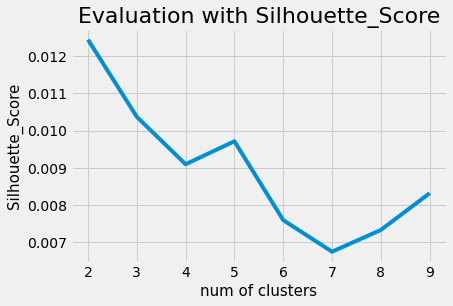

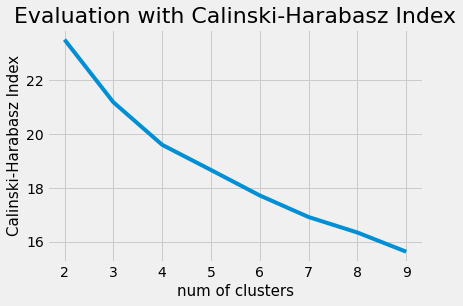

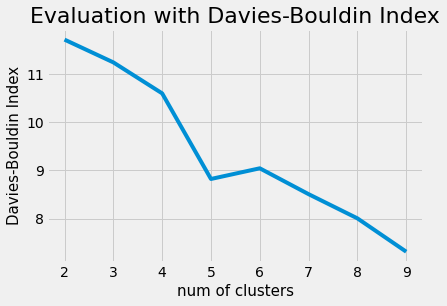

 Elbow Method has been completed .
*****************************************************


<Figure size 432x288 with 0 Axes>

In [44]:
hac_evaluation(X_lsa, n_clusters=[x for x in range(2, 10)], linkage='ward', sparse=False)


#### Results may differ slightly from run to run. You may plot the average over multiple runs if you want to account for stochasticity variance.

The above plots suggest: 
* Silhouette method suggests models k=2, k=3, and k=5 can describe the dataset best. However, all values are close to zero, indicating overlapping clusters.
* Calinski-Harabasz considers k=2 as the most appropriate model and reduces as k increases. Not very accurate considering that we know the real answer.
* Davies-Bouldin Index suggests that more clusters are required to create well-separated clusters. k=9 is the optimal model according to DB index, with k=5,7,8 also describing the data adequately. However, similarly to silhouette the values are far from zero, suggesting clusters are quite similar.

We should bear in mind that we have only provided a small fraction of the actual information due to SVD. \
However, the feature distribution is such that clusters are very hard to form.

Overall: **Models with k=2 and k=5 seem good candidates.**


#### Visualize Clustering 

In [98]:
def plot_clusters(feat_num, data, preds, centroids=None, fig_size=(30, 20), title=''):
    ''' Plot the clusters for every gradient feature pair.
        Parameters:
            feat_num : Controls how many fature pairs are plotted
            data (np.array) : the data to plot.
            preds (np.array) : The cluster labels predicted by the model
            centroids (np.array) : Clusters' centroids, if the model supports it.
            fig_size (tuple(int)): The size of the plt figure. 
            title (str) : The title to use for the figure. '''
    plt.rcParams.update({
        'text.usetex': False,
        'font.family': 'serif',
        "figure.figsize": fig_size
    })
    ng = feat_num
    fig, ax = plt.subplots(ng, ng)
    for j in range(ng):
        for i in range(ng):
            for c in np.unique(preds):
                ax[i][j].scatter(data[preds == c, i],
                                 data[preds == c, j],
                                 label='cluster='+str(c),
                                 alpha=.6,
                                 s=4)
            if centroids: # provide centroids only if model supports it.
                for n, centroid in enumerate(centroids):
                    centroid = centroid.reshape(1, -1)
                    # If Else statement avoids plotting "centroid" legend multiple times.
                    if n == 0:
                        ax[i][j].scatter(centroid[:, i], centroid[:, j], marker='x',
                                        s=4, linewidths=1.8, color='k', label='centroid')
                    else:
                        ax[i][j].scatter(centroid[:, i], centroid[:, j], marker='x',
                                        s=4, linewidths=1.8, color='k')
            ax[i][j].set_xlabel(f'Feature space of feature {i+1} ')
            ax[i][j].set_ylabel(f'Feature {j+1} ')
            ax[i][j].legend(fontsize=12, markerscale=3)
    plt.suptitle(title, fontsize=22)
    plt.tight_layout()
    plt.show()
    plt.clf()  # clear palette

<Figure size 2200x2200 with 0 Axes>

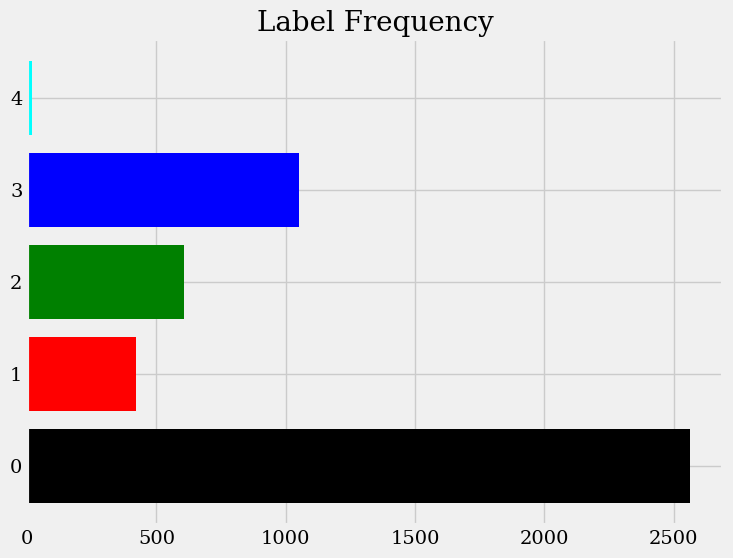

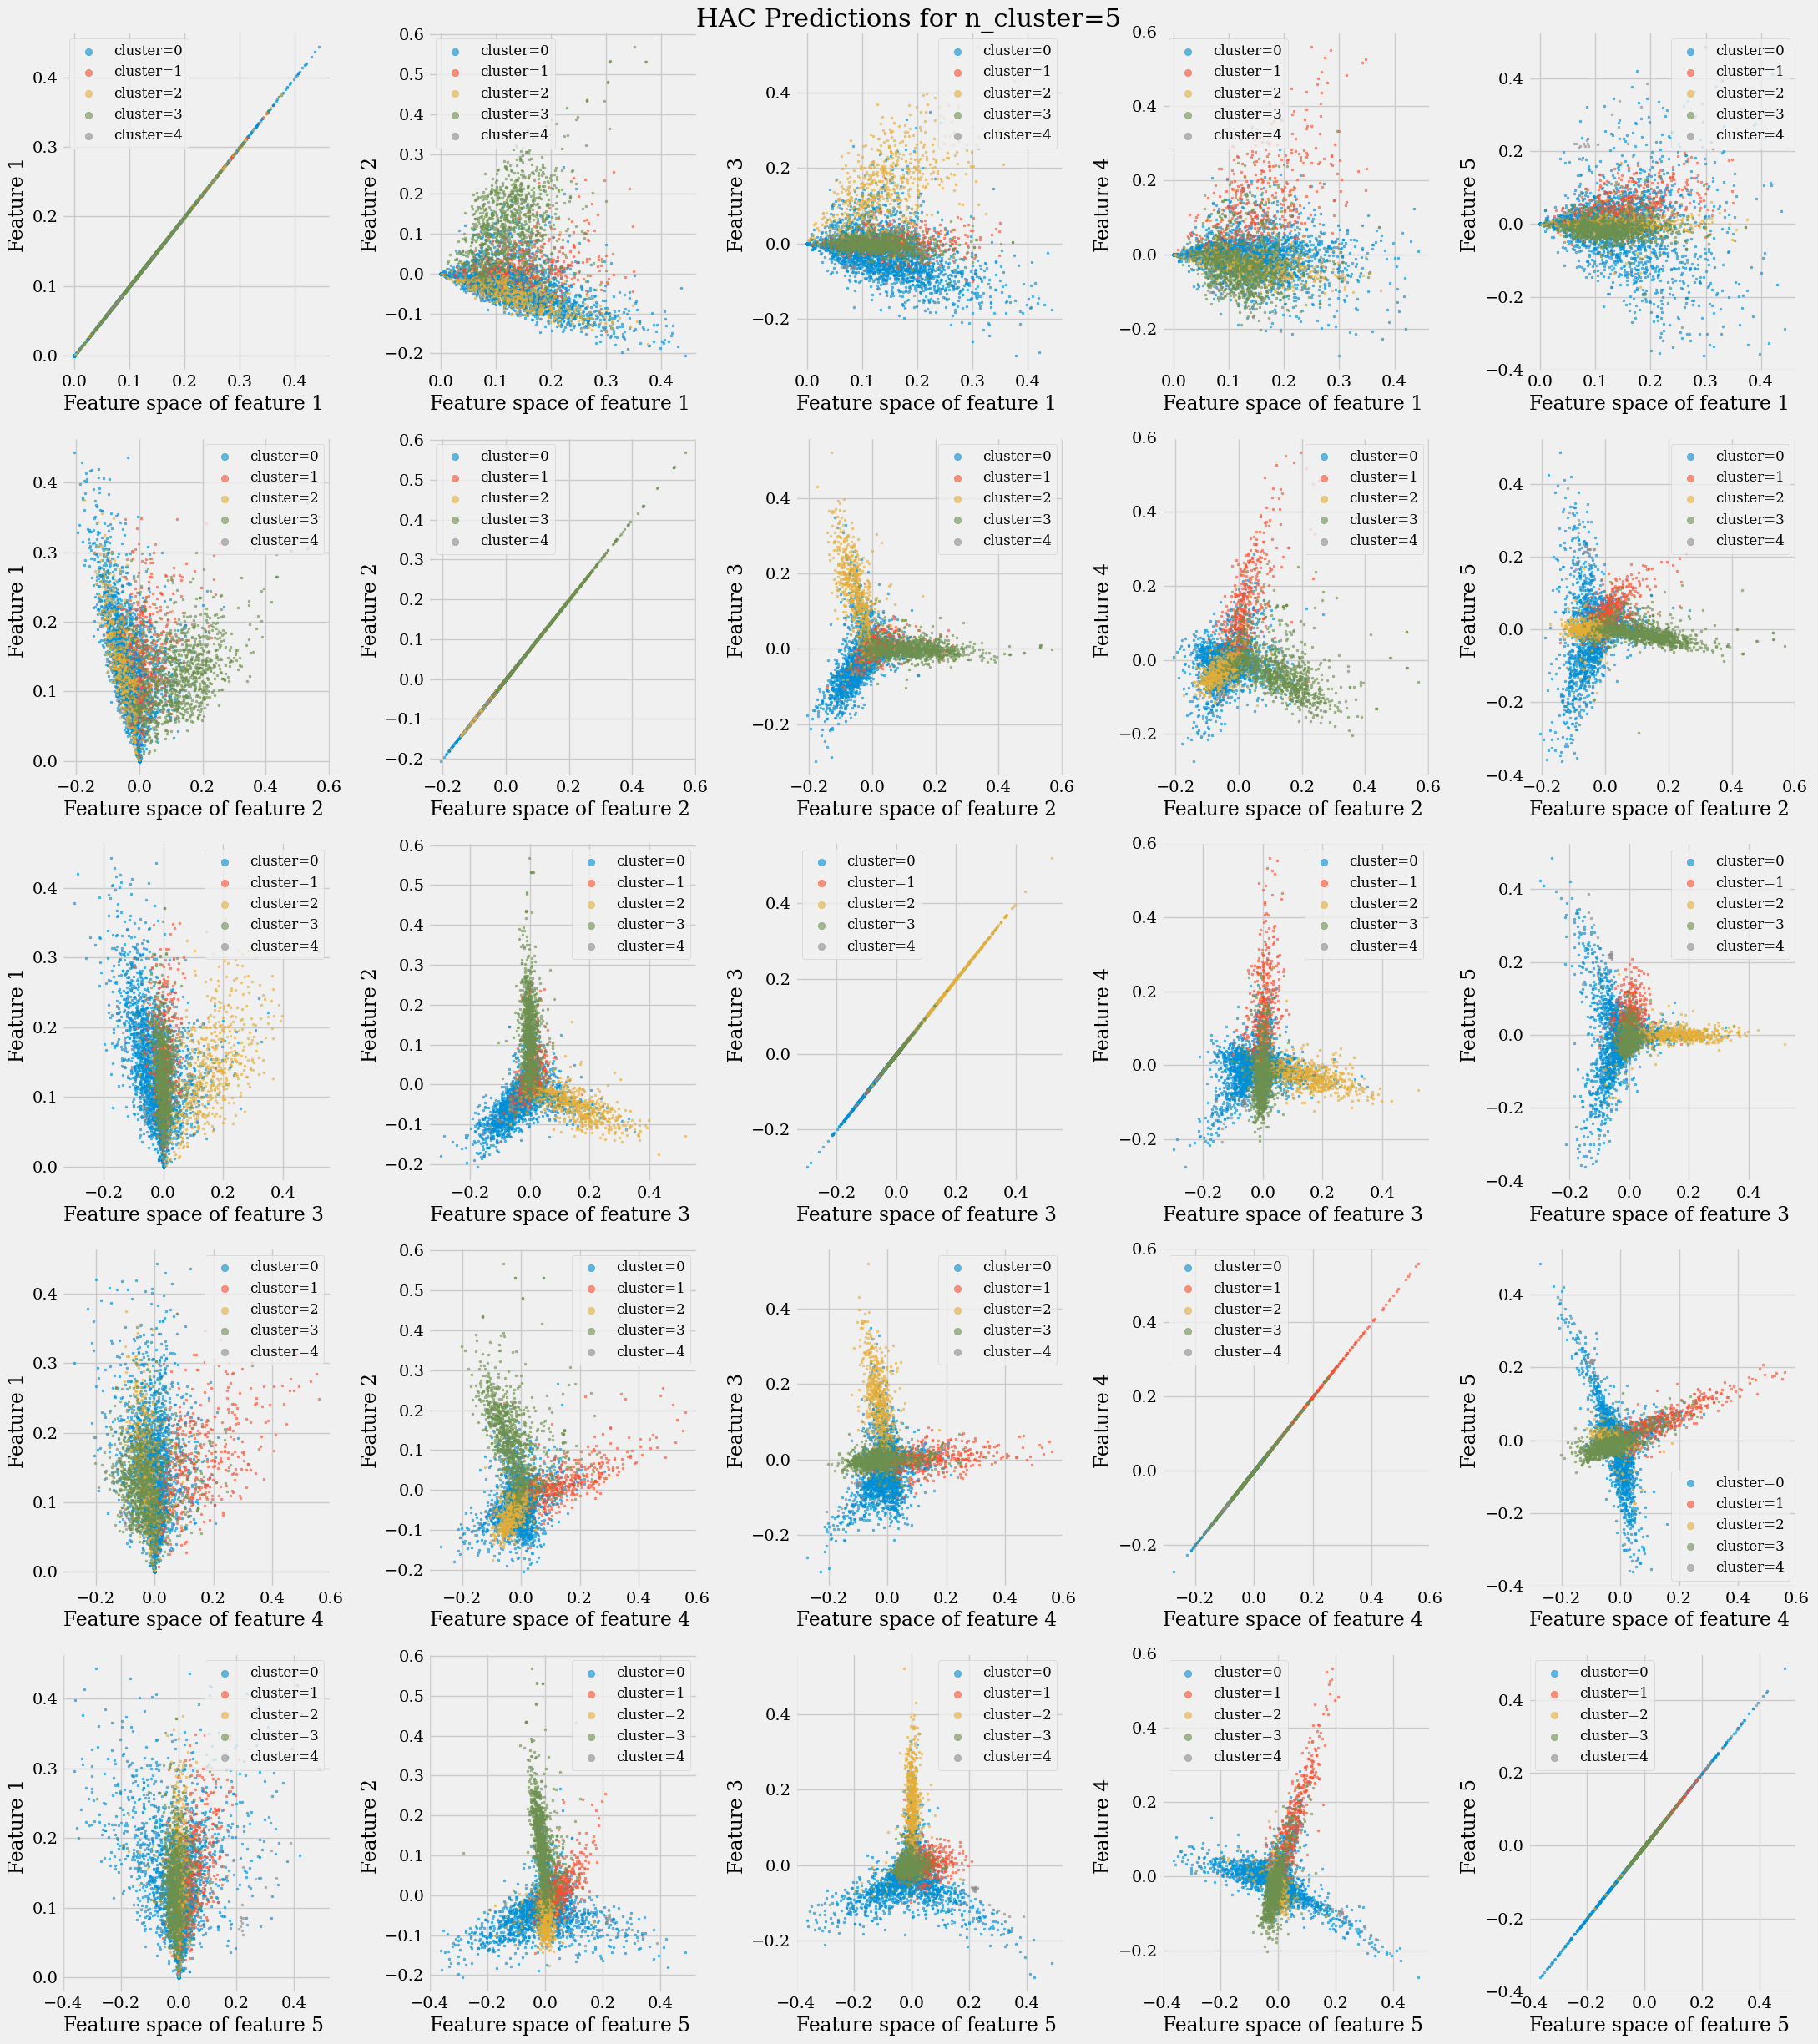

<Figure size 2200x2500 with 0 Axes>

In [101]:
k = 5
hac = AgglomerativeClustering(n_clusters=k, linkage='ward')
hac.fit(X_lsa)

my_colors = ['black', 'red', 'green', 'blue', 'cyan']
plt.clf()
plt.figure(figsize=(8, 6))
unique_elements, element_counts = np.unique(hac.labels_, return_counts=True)
plt.barh(unique_elements, element_counts, color=my_colors)
plt.title('Label Frequency', fontsize=20)
plt.show()
plot_clusters(5, X_lsa, hac.labels_, centroids=None, fig_size=(22, 25),  title='HAC Predictions for n_cluster=5')


<Figure size 2200x2500 with 0 Axes>

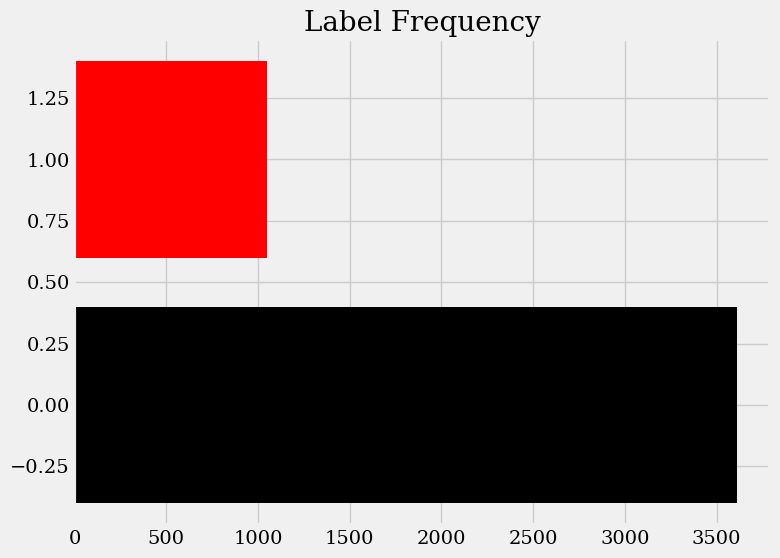

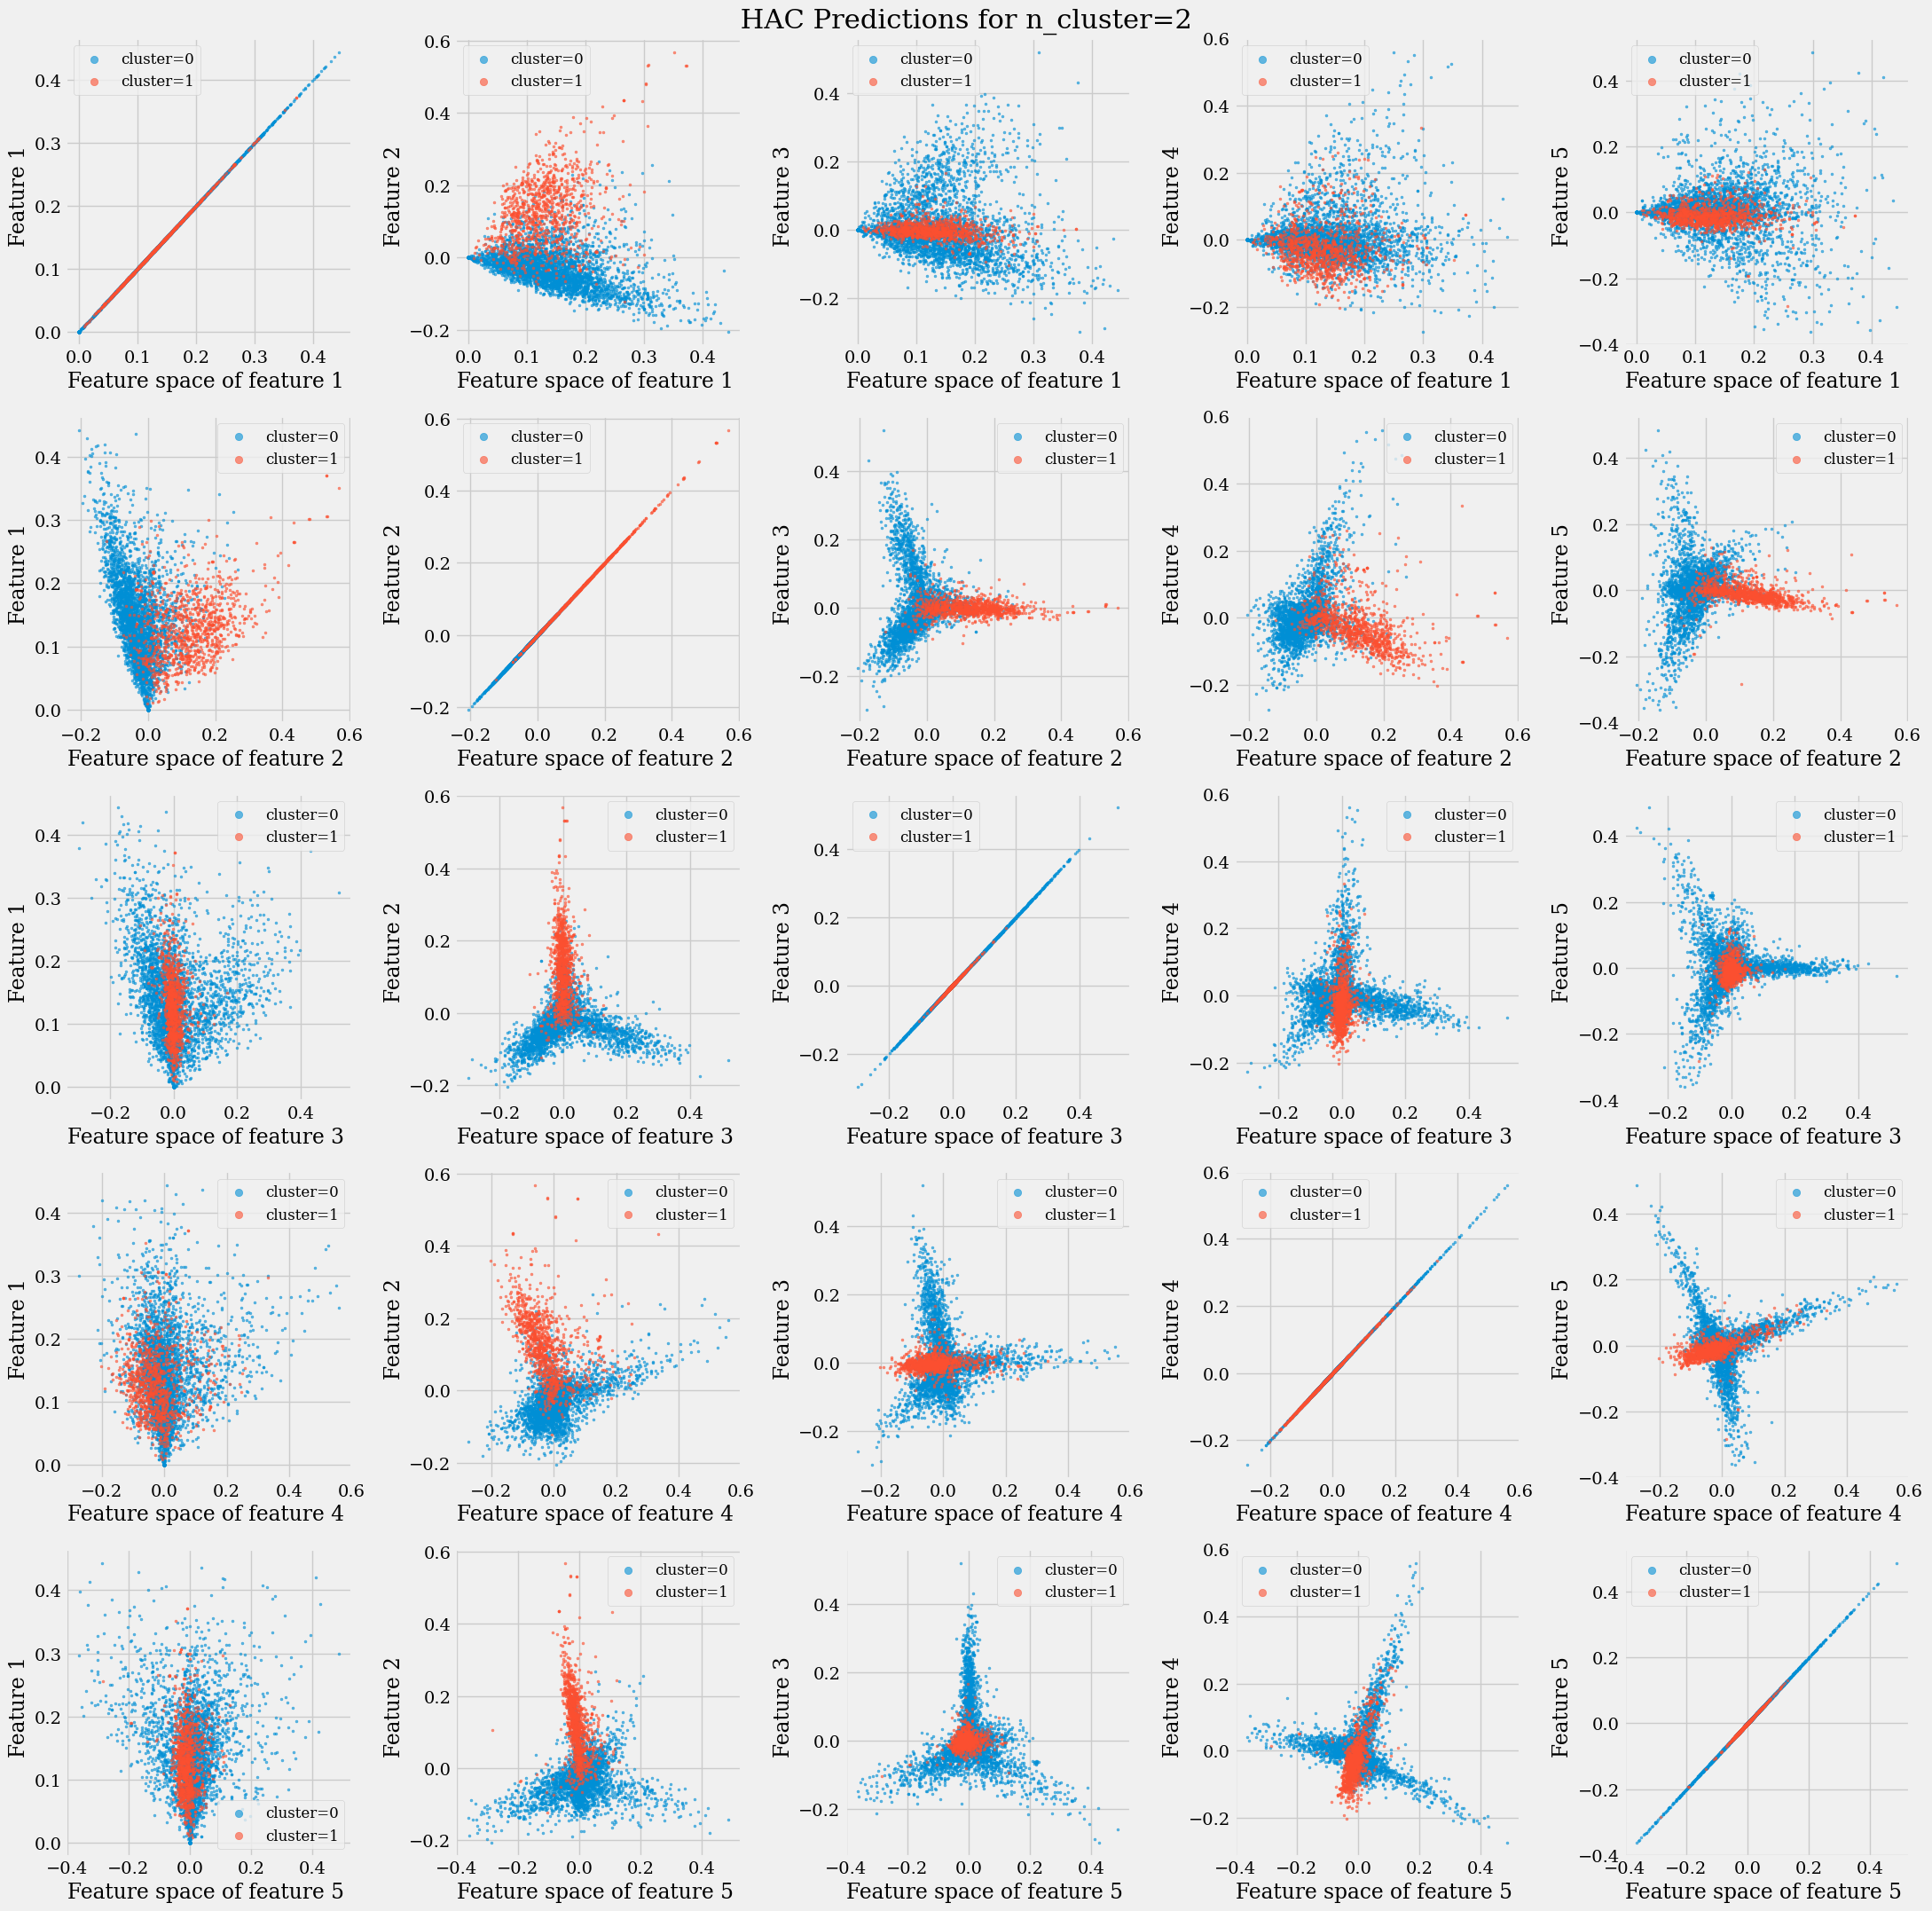

<Figure size 2200x2200 with 0 Axes>

In [100]:
k = 2
hac = AgglomerativeClustering(n_clusters=k, linkage='ward')
hac.fit(X_lsa)

my_colors = ['black', 'red', 'green', 'blue', 'cyan']
plt.clf()
plt.figure(figsize=(8, 6))
unique_elements, element_counts = np.unique(hac.labels_, return_counts=True)
plt.barh(unique_elements, element_counts, color=my_colors)
plt.title('Label Frequency', fontsize=20)
plt.show()

plot_clusters(5, X_lsa, hac.labels_, centroids=None, fig_size=(22, 22),  title=' HAC Predictions for n_cluster=2 ')


### Final thoughts
Even if  we modeled the data with 5 clusters that doesn't mean the algorithm identified them correctly in these 5 categories. Compare the cluster frequencies with label frequencies presented at the beginning. \
It is very possible the model identified 5 groupings based on different criteria that humans did not intend to use when grouping articles into subjects.

However, these methods are useful in determining clustering solutions that can explain data in a meaningful manner. 
